# SELECCIÓN DE CARACTERÍSTICAS. FEATURE SELECTION

### OBJETIVO
El objetivo de este notebook es analizar la importancia de las variables que componen la base de datos.
Para evitar el sobreajuste a la hora de modelizar, reduciremos la dimensionalidad de las variables para eliminar aquellas que no contribuyan significativamente a la capacidad predictiva del modelo, pero de manera cuidadosa sin perder su efectividad. 

En este caso, hemos decidido de entre los métodos de selección de variables implementar la función **SelectFromModel**, en el que las características se consideran no importantes y se eliminan si la importancia correspondiente de los valores de la característica está por debajo del umbral proporcionado.

Dentro de esta función, empleareamos dos estrategias de regularización:
- **Lasso**: El Lasso aplica una penalización L1 que se encarga de limitar el tamaño de los coeficientes, es decir, selecciona automáticamente un subconjunto de características y fuerza algunos coeficientes a cero. Esto significa que algunas características se eliminan por completo del modelo. 
- **Ridge**: Ridge, a diferencia de Lasso, utiliza una penalización L2 y no llega a excluir ninguno de los coeficientes.(Todas las características contribuyen al modelo pero en mayor o menor medida en función de su importancia).

Importamos las librerías necesarias para llevar a cabo esta tarea:

In [44]:
import pandas as pd 
import numpy as np
import sklearn
from sklearn import metrics
import category_encoders as ce

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
#from sklearn.metrics import plot_confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler



A continuación, eliminamos la columna "Unnamed: 0" que aparece por defecto

In [23]:
Base_df = pd.read_csv("../data/base_data_EDA.csv")
if "Unnamed: 0" in Base_df.columns:
    Base_df = Base_df.drop(columns=["Unnamed: 0"])
#Base_df = Base_df.set_index('month')


Vamos a analizar los tipos de variables que tenemos:

In [24]:
Base_df.dtypes

fraud_bool                            int64
income                              float64
name_email_similarity               float64
prev_address_months_count           float64
current_address_months_count        float64
customer_age                        float64
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
zip_count_4w                        float64
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                float64
date_of_birth_distinct_emails_4w    float64
employment_status                    object
credit_risk_score                   float64
email_is_free                       float64
housing_status                       object
phone_home_valid                    float64
phone_mobile_valid                  float64
bank_months_count                   float64
has_other_cards                 

Vemos que seguimos teniendo variables categóricas y nos interesa tener el dataset con todos sus atributos en
formato numérico, ya que es el formato que utilizan los algoritmos de optimización que vamos a implementar.


## 1. Codificación de las variables categóricas


Para preservar los valores originales, optaremos por codificar manualmente las variables categóricas mediante asignación de números. Dado que son pocas, esta estrategia garantiza que no se vean alterados.

In [25]:
Base_df['payment_type'] = Base_df['payment_type'].replace(['AA'],0)
Base_df['payment_type'] = Base_df['payment_type'].replace(['AB'],1)
Base_df['payment_type'] = Base_df['payment_type'].replace(['AC'],2)
Base_df['payment_type'] = Base_df['payment_type'].replace(['AD'],3)
Base_df['payment_type'] = Base_df['payment_type'].replace(['AE'],4)

In [26]:
Base_df['employment_status'] = Base_df['employment_status'].replace(['CA'],0)
Base_df['employment_status'] = Base_df['employment_status'].replace(['CB'],1)
Base_df['employment_status'] = Base_df['employment_status'].replace(['CC'],2)
Base_df['employment_status'] = Base_df['employment_status'].replace(['CD'],3)
Base_df['employment_status'] = Base_df['employment_status'].replace(['CE'],4)
Base_df['employment_status'] = Base_df['employment_status'].replace(['CF'],5)
Base_df['employment_status'] = Base_df['employment_status'].replace(['CG'],6)

In [27]:
Base_df['housing_status'] = Base_df['housing_status'].replace(['BA'],0)
Base_df['housing_status'] = Base_df['housing_status'].replace(['BB'],1)
Base_df['housing_status'] = Base_df['housing_status'].replace(['BC'],2)
Base_df['housing_status'] = Base_df['housing_status'].replace(['BD'],3)
Base_df['housing_status'] = Base_df['housing_status'].replace(['BE'],4)
Base_df['housing_status'] = Base_df['housing_status'].replace(['BF'],5)
Base_df['housing_status'] = Base_df['housing_status'].replace(['BG'],6)

In [28]:
Base_df['source'] = Base_df['source'].replace(['INTERNET'],0)
Base_df['source'] = Base_df['source'].replace(['TELEAPP'],1)

In [29]:
Base_df['device_os'] = Base_df['device_os'].replace(['linux'],0)
Base_df['device_os'] = Base_df['device_os'].replace(['macintosh'],1)
Base_df['device_os'] = Base_df['device_os'].replace(['other'],2)
Base_df['device_os'] = Base_df['device_os'].replace(['windows'],3)
Base_df['device_os'] = Base_df['device_os'].replace(['x11'],3)

Comprobamos que todos los atributos se encuentran finalmente en formato numérico:

In [30]:
Base_df.dtypes

fraud_bool                            int64
income                              float64
name_email_similarity               float64
prev_address_months_count           float64
current_address_months_count        float64
customer_age                        float64
days_since_request                  float64
intended_balcon_amount              float64
payment_type                          int64
zip_count_4w                        float64
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                float64
date_of_birth_distinct_emails_4w    float64
employment_status                     int64
credit_risk_score                   float64
email_is_free                       float64
housing_status                        int64
phone_home_valid                    float64
phone_mobile_valid                  float64
bank_months_count                   float64
has_other_cards                 

In [31]:
Base_df['fraud_bool'].value_counts()

fraud_bool
0    988971
1     11029
Name: count, dtype: int64

La variable objetivo de nuestro modelo de clasificación es "Fraud Bool". Estos números representan la distribución de las clases en la variable objetivo. En este caso, la clase "0" (no fraude) es mucho más predominante que la clase "1" (fraude), lo que sugiere un desbalance de clases en el conjunto de datos. Este desbalance podría requerir técnicas de balanceado de datos más adelante

In [32]:
X = Base_df.drop('fraud_bool', axis=1)  
y = Base_df['fraud_bool']

## 2. Estrategias de regularización

Como comentamos en la introducción, vamos a realizar dos métodos de regularización: Ridge y Lasso. Estos imponen penalizaciones a los coeficientes de las variables según su magnitud. En caso de que las variables tengan escalas distintas, la penalización podría influir de manera desigual en cada variable. Es por ello que las estandarizamos, para igualar las escalas de todas las variables, posibilitando así una comparación equitativa.

In [33]:
scaler = StandardScaler()
model_scaled = scaler.fit(X)
#Creamos un dataframe con los datos escalados
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)

### 2.1 LASSO

In [34]:
sel_lasso = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'), threshold=0.08)
sel_lasso.fit(X_scaled, y)
selected_features = sel_lasso.transform(X)

print('Total de características: {}'.format(X_scaled.shape[1]))
print('Características seleccionadas: {}'.format(selected_features.shape[1]))


Total de características: 31
Características seleccionadas: 22


Lasso nos selecciona 22 características de las 31 totales. Nos elimina 9 al usar un umbral de 0.08

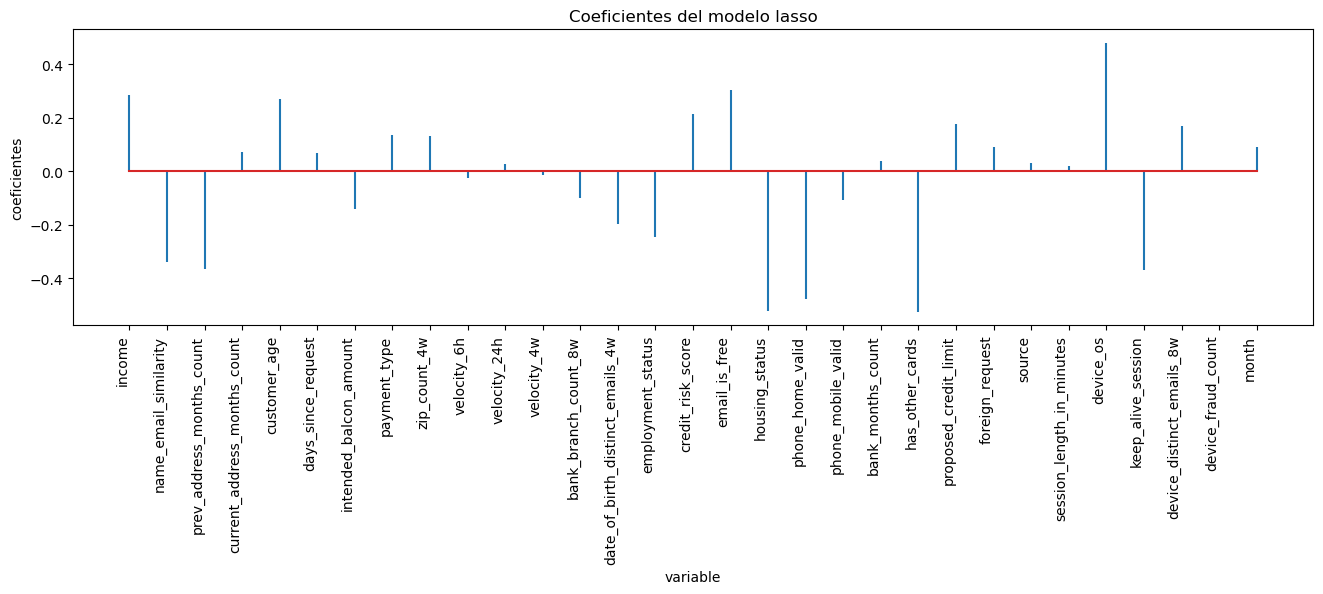

In [35]:
df_coeficientes_lasso = pd.DataFrame(
                        {'predictor': X_scaled.columns,
                         'coef': sel_lasso.estimator_.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes_lasso.predictor, df_coeficientes_lasso.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo lasso');

**Interpretación del gráfico de coeficientes Lasso**

Las barras que se encuentran por encima del eje x indican variables predictoras que tienen un impacto positivo en la variable de respuesta. 

Aquellas positivas con mayor influencia (que las detectamos al tener una mayor altura con respecto al resto), son principalmente la variable income (renta), la edad, el dominio del correo electrónico, la puntuación interna del riesgo de aplicación y el dispositivo que emplean.

Por otro lado, las variables con impacto negativo son principalmente la similaridad de los correos electrónicos, la dirección anterior del solicitante, el estado de la vivienda, la validez del teléfono fijo, si el solicitante tiene otras tarjetas de la misma compañía y la opción del usuario al cerrar cesión.

En términos generales, si analizamos las variables con mayor influencia, es decir, las que tienen una mayor altura, vemos como tienden a ser aquellas con impacto negativo.

In [36]:
nombres_variables_originales = Base_df.columns
variables_seleccionadas = [nombre for nombre, seleccionada in zip(nombres_variables_originales, 
                                                                  sel_lasso.get_support()) if seleccionada]

print("Variables seleccionadas por Lasso:")
print(variables_seleccionadas)

Variables seleccionadas por Lasso:
['fraud_bool', 'income', 'name_email_similarity', 'current_address_months_count', 'days_since_request', 'intended_balcon_amount', 'payment_type', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'employment_status', 'credit_risk_score', 'email_is_free', 'housing_status', 'phone_home_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'session_length_in_minutes', 'device_os', 'keep_alive_session', 'device_fraud_count']


### RIDGE

In [37]:
sel_ridge = SelectFromModel(LogisticRegression(C=1, penalty='l2'), threshold = 1e-4)
sel_ridge.fit(X_scaled, y)

SelectFromModel(estimator=LogisticRegression(C=1), threshold=0.0001)

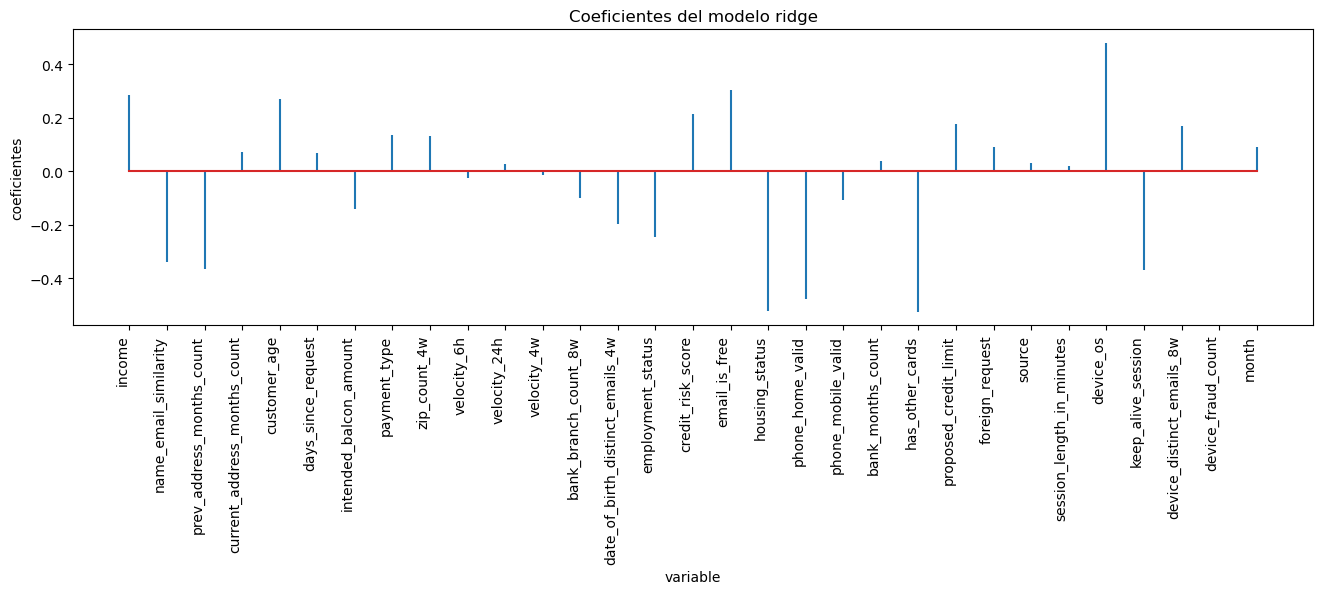

In [38]:
df_coeficientes = pd.DataFrame(
                        {'predictor': X_scaled.columns,
                         'coef': sel_ridge.estimator_.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo ridge');

**Interpretación del gráfico de coeficientes Lasso**

Aquellas positivas con mayor influencia nuevamente vuelven a ser la variable income (renta), la edad, la puntuación interna del riesgo de aplicación, el dominio del correo electrónico y el dispositivo que emplean. Vemos entonces como lasso y ridge coinciden en este aspecto.

Por otro lado, las variables con impacto negativo son principalmente la similaridad de los correos electrónicos, la dirección anterior del solicitante, el estado de la vivienda, la validez del teléfono fijo y móvil, si el solicitante tiene otras tarjetas de la misma compañía y la opción del usuario al cerrar cesión.

Podemos deducir con ello que aunque lasso y ridge seleccionen un número distinto de variables, si que coinciden en la influencia y el impacto que tienen las variables.

In [39]:
sel_ridge.get_support()
selected_feat = X_scaled.columns[sel_ridge.get_support()]
selected_feat

Index(['income', 'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'payment_type', 'zip_count_4w', 'velocity_6h',
       'velocity_24h', 'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'month'],
      dtype='object')

In [40]:
print('total features: {}'.format((X_scaled.shape[1])))
print('selected features: {}'.format(len(selected_feat)))

total features: 31
selected features: 30


Ridge selecciona 30 de las 31 variables.

Como vemos, la regresión Ridge solo elimina una característica. Nuestro conjunto de datos tiene muchas características y algunas de ellas seguramente sea redundantes o no contribuyan significativamente a la tarea de predicción. Lasso nos ha seleccionado 22 variables, que serán las que finalmente elijamos para el modelo, ya que así se simplifica mucho más y se mejora su interpretabilidad.

Creamos un dataframe reducido que incluya solamente aquellas variables seleccionadas por Lasso.

In [41]:
Base_df_reducido = Base_df[variables_seleccionadas]
print(Base_df_reducido.head())

   fraud_bool  income  name_email_similarity  current_address_months_count  \
0           1     0.9               0.166828                          88.0   
1           1     0.9               0.296286                         144.0   
2           1     0.9               0.044985                         132.0   
3           1     0.9               0.159511                          22.0   
4           1     0.9               0.596414                         218.0   

   days_since_request  intended_balcon_amount  payment_type  velocity_4w  \
0            0.020925               -1.331345             0  3863.647740   
1            0.005418               -0.816224             1  3124.298166   
2            3.108549               -0.755728             2  3159.590679   
3            0.019079               -1.205124             1  3022.261812   
4            0.004441               -0.773276             1  3087.670952   

   bank_branch_count_8w  date_of_birth_distinct_emails_4w  ...  email_is_f

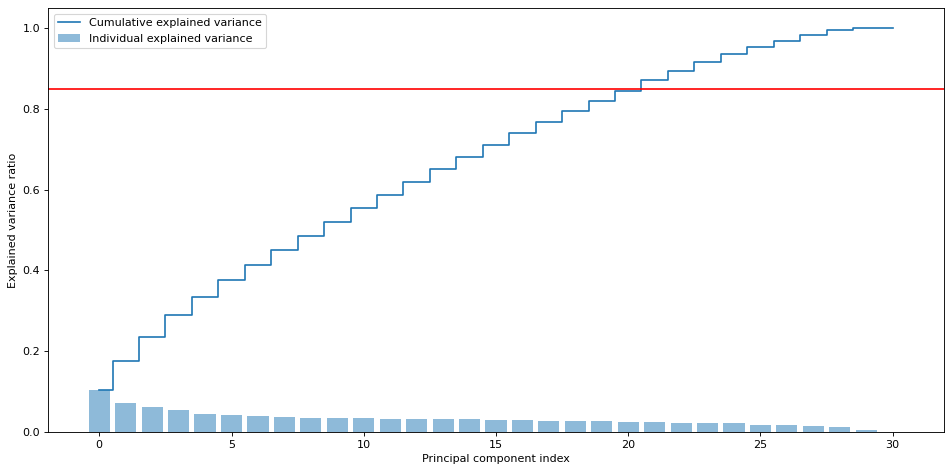

In [49]:
pca = PCA()
pca.fit(X_scaled)
exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

threshold = 0.85
plt.figure(figsize=(12, 6), dpi=80)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.axhline(y=threshold, color='r', linestyle='-')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Vemos cómo con tal solo los 20 primeros componentes se explica la mayor parte de la varianza (75%)

A continuación, seleccionamos las 22 primeras variables para analizarlo mejor :


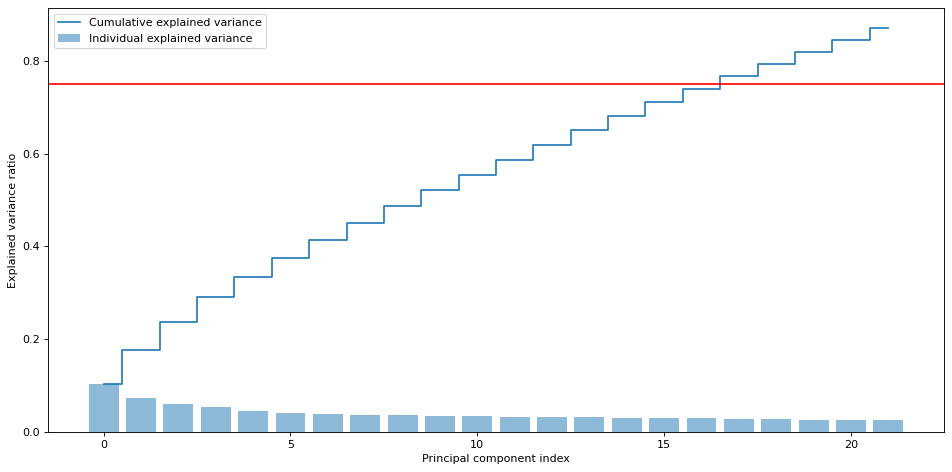

In [51]:
pca = PCA(n_components=22)

pca.fit(X_scaled)
X_train_pca = pca.transform(X_scaled)

exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

threshold = 0.75
plt.figure(figsize=(12, 6), dpi=80)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.axhline(y=threshold, color='r', linestyle='-')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [58]:
Base_df.to_csv("../data/base_data02_preprocessing.csv")
Base_df_reducido.to_csv("../data/base_reduced_data_preprocessing.csv")

### CONCLUSIONES
En primer lugar, hemos transformado las variables categóricas a formato numérico de forma manual, así que ya codificadas, no nos hará falta realizar el OneHot Enconding más adelante.

Seguidamente, las hemos escalado y hemos realizado las **técnicas de regularización** con el objetivo de seleccionar las variables más importantes y así reducir la dimensionalidad del conjunto de datos.

Lasso nos ha seleccionado **22 variables** a partir de la penalización L1, mientras que Ridge solo nos ha eliminado una variable a través de la penalización L2. Es por ello que hemos decidido seguir las recomendaciones de Lasso y quedarnos con las variables que ha mantenido.

Por otro lado, realizando el PCA, vemos que la **mayor parte de la varianza queda recogida en los 20 primeros componentes**, así que seleccionando 22 atributos conseguimos la mayor parte de la información relevante con una reducción significativa en la dimensionalidad del conjunto de datos. Esto simplifica el modelo y agiliza los procesos computacionales, al tiempo que preserva la mayor cantidad posible de información distintiva.

Finalmente, hemos creado un dataframe reducido con las variables unicamente seleccionadas.